# Lab 2: Classification

### Machine Learning 1, September 2016

* The lab exercises should be made in groups of two people.
* The deadline is October 9th (Sunday) 23:59.
* Assignment should be sent to your teaching assistant. The subject line of your email should be "lab\#\_lastname1\_lastname2\_lastname3".
* Put your and your teammates' names in the body of the email.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "lab01\_Kingma\_Hu", the attached file should be "lab01\_Kingma\_Hu.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* For this notebook you need to answer a few theory questions, add them in the Markdown cell's below the question. Note: you can use Latex-style code in here.
* Focus on Part 1 the first week, and Part 2 the second week!
* You should write your code and answers below the questions in this IPython Notebook.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* If you have questions outside of the labs, post them on blackboard or email me.
* NOTE: Make sure we can run your notebook / scripts!

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [1]:
%pylab inline
import gzip, cPickle

Populating the interactive namespace from numpy and matplotlib


# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can load the data from `mnist.pkl.gz` we provided, using: 

In [6]:

def load_mnist():
    f = gzip.open('mnist.pkl.gz', 'rb')
    data = cPickle.load(f)
    f.close()
    return data

(x_train, t_train), (x_valid, t_valid), (x_test, t_test) = load_mnist()



The tuples represent train, validation and test sets. The first element (`x_train`, `x_valid`, `x_test`) of each tuple is a $N \times M$ matrix, where $N$ is the number of datapoints and $M = 28^2 = 784$ is the dimensionality of the data. The second element (`t_train`, `t_valid`, `t_test`) of each tuple is the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

8
2


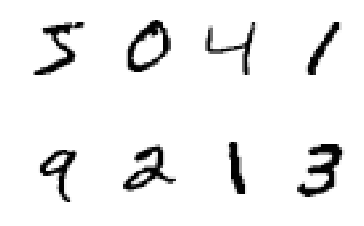

In [9]:
def plot_digits(data, numcols, shape=(28,28)):
    numdigits = data.shape[0]
    print(numdigits)
    numrows = int(numdigits/numcols)
    print(numrows)
    for i in range(numdigits):
        plt.subplot(numrows, numcols, i+1)
        plt.axis('off')
        plt.imshow(data[i].reshape(shape), interpolation='nearest', cmap='Greys')
    plt.show()
    
plot_digits(x_train[0:8], numcols=4)

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_j \exp(\log q_j)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

Warning: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization

### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.
%display latex
You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log p_j}
\frac{\partial \log p_j}{\partial \log q_j}
+ \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1 \cdot 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
= 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$

For $j \neq t^{(n)}$:
$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

#####Answer: 

For $j = t^{(n)}$:
$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log p_j}
\frac{\partial \log p_j}{\partial \log q_j}
+ \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1 \cdot 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
= 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}=1-\frac{1}{Z} \cdot q_j
$

For $j \neq t^{(n)}$:
$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}=-\frac{1}{Z} \cdot q_j
$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
=\mathbf{\delta}_j^q \cdot x_{(n)i}
$

### 1.1.2 Implement gradient computations (10 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).


In [10]:
K=10 #10 classifications   
M=784 #dimensional

def logreg_gradient(x, t, w, b):
    '''returns the gradients of parameters at a single datapoint'''
    
    grad_w=[]  #a 784×10 matrix;
    grad_b=[]  #a 10×1 vector;
    vec_delta=[]#a 10×1 vector;
    K=10 #10 classifications   
    M=784 #dimensional
    x=np.array(x)
    b=np.array(b)
    w_T=w.T
    
    vec_log_q=[]#a 10×1 vector;
    for j in range(K):
        
        vec_log_q.append(    np.log(np.dot(w_T[j],x.T)+b[j] )    )
    #computing Z.
    a= np.amax(vec_log_q)
    
    s=0
    for j in range(K):
        log_q=vec_log_q[j]
        s=s+np.exp(log_q-a)
    log_Z=a + np.log(s)
    Z=np.exp(log_Z)
    #computing log_p.
    log_q=vec_log_q[t]
    log_p= log_q-log_Z
    q=np.exp(log_q)
    #computing gradients.
    for j in range(K):
        if j == t:
            delta = -(1/Z) * q
        else:
            delta = 1 - (1/Z) * q
        
        vec_delta.append(delta)
        grad_b.append(delta)
        grad_w_j=[delta * x[i] for i in range(M)]
        grad_w.append(grad_w_j)
        
    
    grad_w= np.array(grad_w).T
    grad_b=np.array(grad_b).T
    #print(grad_b)
    return grad_b,grad_w
       


### 1.1.3 Stochastic gradient descent (10 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters using a small learning rate (e.g. `1E-4`). Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [11]:
def sgd_iter(x_train, t_train, w, b):
    ''' one iteration of stochastic gradient descent'''
    lamb=1e-4
    n=numpy.random.randint(len(x_train))
    x=x_train[n]#randomly select a datapoint.
    #print(x)
    t= t_train[n]
    grad_b,grad_w=logreg_gradient(x, t, w, b)
    grad_w=np.array(grad_w)
    w_new=w-lamb * grad_w
    b=b-lamb * grad_b
    return w_new,b,x,t       
    

## 1.2. Train

### 1.2.1 Train (10 points)
Perform a handful of training iterations through the trainingset. Plot (in one graph) the conditional log-probability of the trainingset and validation set after each iteration.


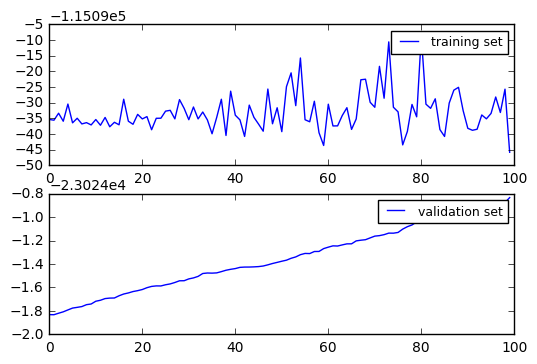

In [12]:
def log_p(x,t,w,b):
    x=np.array(x)
    b=np.array(b)
    w_T=w.T
    vec_log_q=[]#a 10×1 vector;
    for j in range(K):        
        vec_log_q.append(    np.log(np.dot(w_T[j],x.T)+b[j] )    )
    #computing Z.
    a= np.amax(vec_log_q)
    s=0
    for j in range(K):
        log_q=vec_log_q[j]
        s=s+np.exp(log_q-a)
    log_Z=a + np.log(s)
    Z=np.exp(log_Z)
    #computing log_p.
    log_q=vec_log_q[t]
    log_p= log_q-log_Z
    q=np.exp(log_q)
    return log_p


w=np.ones((M,K)) #initialize
b=np.zeros(K)
array_log_pro=[]
array_log_pro_val=[]
iteration=100
for i in range(iteration):
    w,b,x,t=sgd_iter(x_train, t_train, w, b)
    #conditional log-probability of the trainingset 
    log_pro=0
    for j in range(len(x_train)):
        log_pro += log_p(x,t,w,b)
    array_log_pro.append(log_pro)
    
    #conditional log-probability of the validation set 
    log_pro_val=0
    for j in range(len(x_valid)):

        log_pro_val += log_p(x_valid[j],t_valid[j],w,b)
    array_log_pro_val.append(log_pro_val)
    
     
  


plt.subplot(2,1,1)    
plt.plot([i for i in range(iteration)],array_log_pro,label='training set')
plt.legend(fontsize=9)   
plt.subplot(2,1,2)  
plt.plot([i for i in range(iteration)],array_log_pro_val,label='validation set')
plt.legend(fontsize=9)    

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.

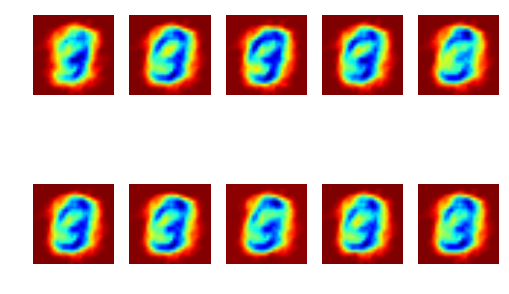

In [18]:
def plot_weights(data, shape=(28,28)):
    for i in range(K):
        plt.subplot(2, 5, i+1)
        plt.axis('off')
        plt.imshow(data.T[i].reshape(shape))
    plt.show()
    
plot_weights(w)


### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.
Ask yourself if these results make sense.

[3575 3800  534 8718 7746 8784 9105 4414  718 3647 8312 4366 8753 3620 4902
 5442]


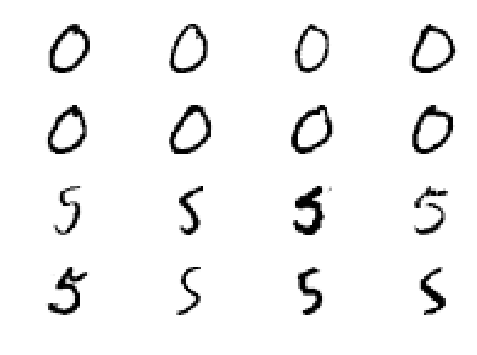

In [19]:

def largest(a,N):#rerturns the indice of the N largest numbers.
    return np.argsort(a)[::-1][:N]
def smallest(a,N):#rerturns the indice of the N smallest numbers.
    return np.argsort(a)[:N]

array_log_pro_val=[]
for j in range(len(x_valid)):
    array_log_pro_val.append(log_p(x_valid[j],t_valid[j],w,b)) 
    index_easy=largest(array_log_pro_val,8)
    index_hard=smallest(array_log_pro_val,8)
index=np.concatenate((index_easy, index_hard), axis=0)
print(index)
data=[x_valid[i] for i in index]
data=np.array(data)
plot_digits(data,  numcols=4)    
#From the outcome it sinces make sense, because 0 is really easy to learn and 5 sinces hard to figure even with eyes,
#and has quite different configureations.

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron wil have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$.

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

#####Answer: 

The following show how we can compute $\delta^h$

$\mathcal{L}^{(n)} = \log q_j - \log Z = \mathbf{w}_j^T \mathbf{h} + b_j - \log Z = \sum_{i=1}^L W_{ij}\sigma(\mathbf{v}_i^T \mathbf{x} + a_i) + b_j - \log Z = \sum_{i=1}^L W_{ij}\sigma(\sum_{k=1}^{784} v_{ki}x_k + a_i) + b_j - \log Z$

$\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$

For $j = t^{(n)}$: $\delta_j^q = 1 - \dfrac{1}{Z}exp(\log q_j)$

For $j \neq t^{(n)}$: $\delta_j^q = -\dfrac{1}{Z}exp(\log q_j)$

$\delta_i^h = \dfrac{\partial \mathcal{L}^{(n)}}{\partial h_i} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log q_j} \dfrac{\partial \log q_j}{\partial h_i} = \delta_j^q W_{ij}$

Furhter, the corresonding derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$ is presented below 

$\dfrac{\partial \mathcal{L}^{(n)}}{\partial b_j} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log q_j} \dfrac{\partial \log q_j}{\partial b_j} = \delta_j^q$

$\dfrac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}\dfrac{\partial \log q_j}{\partial \log W_{ij}} = \delta_j^q h_i$

$\dfrac{\partial \mathcal{L}^{(n)}}{\partial a_i} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial h_i} \dfrac{\partial h_i}{\partial (\mathbf{v_i}^T\mathbf{x} + a_i)}  \dfrac{\partial(\mathbf{v_i}^T\mathbf{x} + a_i)}{\partial a_i} = \delta_i^h \sigma(\mathbf{v_i}^T\mathbf{x} + a_i)(1 - \sigma(\mathbf{v_i}^T\mathbf{x} + a_i)) = \delta_i^h h_i (1 - h_i)$

$\dfrac{\partial \mathcal{L}^{(n)}}{\partial v_{ki}} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial h_i} \dfrac{\partial h_i}{\partial(\mathbf{v_i}^T\mathbf{x} + a_i)}  \dfrac{\partial(\mathbf{v_i}^T\mathbf{x} + a_i)}{\partial a_i} = \delta_i^h \sigma(\mathbf{v_i}^T\mathbf{x} + a_i)(1 - \sigma(\mathbf{v_i}^T\mathbf{x} + a_i))x_k = \delta_i^h h_i(1 - h_i)x_k$






## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

#####Answer: 

$\mathcal{L}^{(n)} = \log q_j - \log Z - \dfrac{\alpha_1}{2}\sum_{k=1}^{784}\sum_{i=0}^L v_{ki}^2 - \dfrac{\alpha_2}{2} \sum_{i=0}^L\sum_{j=1}^{10} W_{ij}^2 $

$\dfrac{\partial \mathcal{L}^{(n)}}{\partial b_j} = \delta_j^q$

$\dfrac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} = \delta_j^q h_i - \alpha_2 W_{ij}$

$\dfrac{\partial \mathcal{L}^{(n)}}{\partial a_i} = \delta_i^h h_i (1 - h_i)$

$\dfrac{\partial \mathcal{L}^{(n)}}{\partial v_{ki}} = \delta_i^h h_i (1 - h_i)x_k - \alpha_1 v_{ki}$

<!-- Bishop 5.5.1 -->

## 2.3. Implement and train a MLP (15 points)

Implement a MLP model with a single hidden layer, and code to train the model.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def mlp_init(nr_feature, nr_class, nr_element):
    a = (np.random.random_sample(nr_element) - 0.5) * 0.001
    b = (np.random.random_sample(nr_class) - 0.5) * 0.001
    V = (np.random.random_sample((nr_feature, nr_element)) - 0.5) * 0.001
    W = (np.random.random_sample((nr_element, nr_class)) - 0.5) * 0.001
    return a, b, V, W

def mlp_gradient(x, t, a, b, V, W, a1, a2):
    h = 1 / (1 + np.exp(-x.dot(V) - a))
    logq = h.dot(W) + b

    a = np.max(logq)
    logZ = a + np.log(np.sum(np.exp(logq - a)))
    Z = np.exp(logZ) 

    grad_b = -np.exp(logq) / Z
    grad_b[t] += 1

    grad_W = h[np.newaxis].T.dot(grad_b[np.newaxis]) - a1 * W

    grad_h = W[:,t].dot(grad_b[t])
    grad_a = grad_h * h * (1 - h)

    grad_V = x[np.newaxis].T.dot(grad_a[np.newaxis]) - a2 * V
    return grad_a, grad_b, grad_V, grad_W

#To check!
nr_feature = x_train.shape[1]
nr_class = 10
nr_element = 100
a1 = 0.001
a2 = 0.001
a, b, V, W = mlp_init(nr_feature, nr_class, nr_element)
grad_a, grad_b, grad_V, grad_W = mlp_gradient(x_train[0], t_train[0], a, b, V, W, a1, a2)
print grad_a.shape, grad_b.shape, grad_V.shape, grad_W.shape

(100,) (10,) (784, 100) (100, 10)


In [20]:
def sgd_mlp_iter(x_train, t_train, a, b, V, W, lr, a1, a2):
    indexes = np.arange(len(x_train))
    np.random.shuffle(indexes)
    for index in indexes:
        grad_a, grad_b, grad_V, grad_W = mlp_gradient(x_train[index], t_train[index], a, b, V, W, a1, a2)
        a += lr * grad_a
        b += lr * grad_b
        V += lr * grad_V
        W += lr * grad_W
        
#update a, b, V, W
lr=0.001
a, b, V, W = mlp_init(nr_feature, nr_class, nr_element)
sgd_mlp_iter(x_train, t_train, a, b, V, W, lr, a1, a2)

In [21]:
def get_loglikelihood(x, t, a, b, V, W):
    h = 1 / (1 + np.exp(-x.dot(V) - a))
    logq = h.dot(W) + b

    a = np.max(logq)
    logZ = a + np.log(np.sum(np.exp(logq - a)))

    loglikelihood = np.sum(np.array([logq[index, value] for (index,), value in np.ndenumerate(t)]) - logZ)
    return loglikelihood

print get_loglikelihood(x_train, t_train, a, b, V, W)

-643184.134362


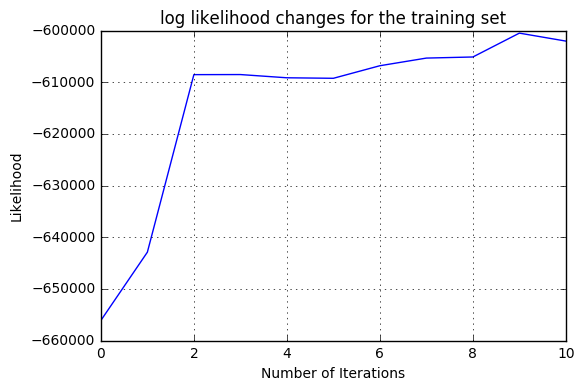

In [11]:
def mlp_train(a, b, V, W, lr, nr_iter, a1, a2, cl=True):
    loglikelihood_train = []
    if cl:
        loglikelihood_train.append(get_loglikelihood(x_train, t_train, a, b, V, W))
    for i in xrange(nr_iter):
        sgd_mlp_iter(x_train, t_train, a, b, V, W, lr, a1, a2)
        if cl:
            loglikelihood_train.append(get_loglikelihood(x_train, t_train, a, b, V, W))

    return loglikelihood_train

#get log-likelihood plot w.r.t. number of iterations
#initilization parameters
a, b, V, W = mlp_init(nr_feature, nr_class, nr_element)
lr = 0.001
nr_iter = 10

llikelihood = mlp_train(a, b, V, W, lr, nr_iter, a1, a2, cl=True)
r = np.arange(len(llikelihood))
plt.plot(r, llikelihood)
plt.title('log likelihood changes for the training set')
plt.ylabel('Likelihood')
plt.xlabel('Number of Iterations')
plt.grid(True)
plt.show()

accuracy =  0.3517


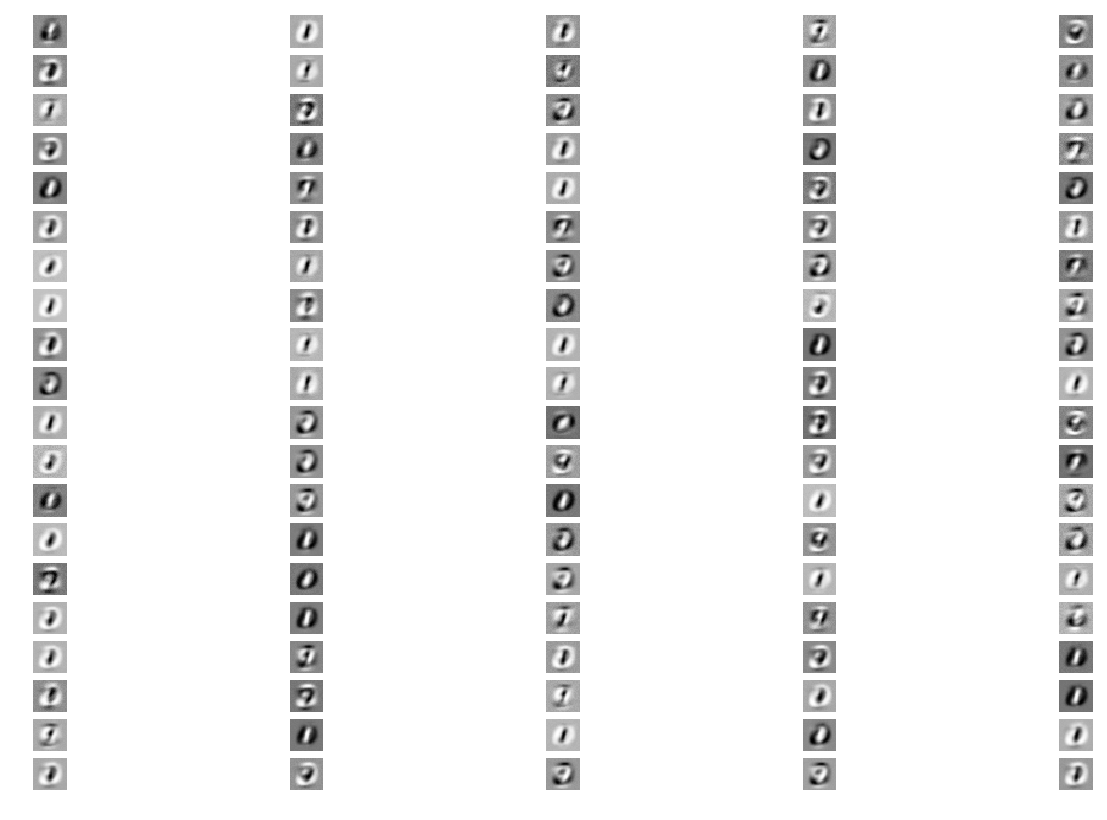

In [ ]:
#Prediction
def mlp_predict(a, b, V, W, x):
    h = 1 / (1 + np.exp(-x.dot(V) - a))
    logq = h.dot(W) + b
    return np.argmax(logq, axis=1)

#check accuracy
prediction = mlp_predict(a, b, V, W, x_valid)
correctness = t_valid == prediction
accuracy = len(correctness[correctness == True]) / float(len(t_valid))
print 'accuracy = ', accuracy

#plot
figure = plt.figure()
figure.set_size_inches((16, 10))
plot_digits(V.T, numcols=5)

### 2.3.1. Less than 250 misclassifications on the test set (10 bonus points)

You receive an additional 10 bonus points if you manage to train a model with very high accuracy: at most 2.5% misclasified digits on the test set. Note that the test set contains 10000 digits, so you model should misclassify at most 250 digits. This should be achievable with a MLP model with one hidden layer. See results of various models at : `http://yann.lecun.com/exdb/mnist/index.html`. To reach such a low accuracy, you probably need to have a very high $L$ (many hidden units), probably $L > 200$, and apply a strong Gaussian prior on the weights. In this case you are allowed to use the validation set for training.
You are allowed to add additional layers, and use convolutional networks, although that is probably not required to reach 2.5% misclassifications.

In [ ]:
best_L = 0
best_a1 = 0
best_a2 = 0
best_accuracy = 0

#To find the best parameter, but it should be mentioned that the whole process takes a very long time...
nr_iter = 10
for a1 in [0.001, 0.005, 0.01]:
    for a2 in [0.001, 0.005, 0.01]:
        for nr_element in [100, 150, 200, 250]:
            np.random.seed(0)
            a, b, V, W = mlp_init(nr_feature, nr_class, nr_element)
            mlp_train(a, b, V, W, lr, nr_iter, a1, a2, cl=False )
            prediction = mlp_predict(a, b, V, W, x_valid)
            correctness = t_valid == prediction
            accuracy = len(correctness[correctness == True]) / float(len(t_valid))
            print 'best_ele =', nr_element, 'a1 =', a1, 'a2 =', a2, 'accuracy =', accuracy
            if accuracy > best_accuracy:
                best_L = nr_element
                best_a1 = a1
                best_a2 = a2
                best_accuracy = accuracy

print best_a1, best_a2, best_L 

best_ele = 100 a1 = 0.001 a2 = 0.001 accuracy = 0.9062
